# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install libraries

In [2]:
!pip install prophet


# Import Libraries

In [3]:
#Load the required libraries

import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

import joblib

import yfinance as yf

import prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


# Import Data

In [4]:
bitcoin_df = yf.download(tickers = 'BTC-USD', start="2015-01-01", end="2023-06-30",  interval = "1d")

bitcoin_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


Here's a breakdown of each feature:

- **Date**: Date of the trade
- **Open**: The price at which the stock began
- **High**: Highest price during that trading day
- **Low**: Lowest price during that trading day
- **Close**: The price at which the stock ended
- **Adj Close**: The closing price after adjustments for splits, right offeruings and dividends, to make prices comparable over time
- **Volume**: Total stocks traded that day

In [5]:
bitcoin_df.reset_index(inplace = True)
bitcoin_df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650


In [6]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3102 non-null   datetime64[ns]
 1   Open       3102 non-null   float64       
 2   High       3102 non-null   float64       
 3   Low        3102 non-null   float64       
 4   Close      3102 non-null   float64       
 5   Adj Close  3102 non-null   float64       
 6   Volume     3102 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 169.8 KB


# Modeling

In [7]:
bitcoin_df.shape

(3102, 7)

In [8]:
# Split the dataset into train and test sets

train_set, test_set = train_test_split(bitcoin_df, test_size=0.2, shuffle=False)

print(train_set.shape)
print(test_set.shape)

(2481, 7)
(621, 7)


In [9]:
## Model

# Define the columns for the regressors
columns = ['Open', 'High', 'Low', 'Volume', 'Adj Close']

# Create the Prophet model
model = Prophet()

# Add the regressors to the model
for feature in columns:
    model.add_regressor(feature)

# Prepare the training data
train_data = train_set[['Date', 'Close'] + columns].rename(columns={'Date': 'ds', 'Close': 'y'})

# Fit the model to the training data
model.fit(train_data)

# Prepare the test data for forecasting
test_data = test_set[['Date', 'Close'] + columns].rename(columns={'Date': 'ds'})

# Generate the forecast
forecast = model.predict(test_data)

# Display the first few rows of the forecast
forecast.head()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpus9rpmse/gx1e4fwk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpus9rpmse/1gxyjuyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16357', 'data', 'file=/tmp/tmpus9rpmse/gx1e4fwk.json', 'init=/tmp/tmpus9rpmse/1gxyjuyd.json', 'output', 'file=/tmp/tmpus9rpmse/prophet_model04p9p0ia/prophet_model-20230704135652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:56:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:57:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Adj Close,Adj Close_lower,Adj Close_upper,High,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-10-17,9810.888277,61539.886068,61568.158153,9810.888277,9810.888277,51753.131539,51753.131539,51753.131539,-26.240563,...,-0.033925,-0.033925,-0.033925,0.187517,0.187517,0.187517,0.0,0.0,0.0,61554.637351
1,2021-10-18,9810.886707,62012.325651,62041.682845,9810.886707,9810.886707,52225.696008,52225.696008,52225.696008,-26.733616,...,0.014962,0.014962,0.014962,0.190736,0.190736,0.190736,0.0,0.0,0.0,62026.960699
2,2021-10-19,9810.885137,64248.948102,64277.702739,9810.885137,9810.885137,54462.100029,54462.100029,54462.100029,-27.659487,...,-0.006906,-0.006906,-0.006906,0.194360,0.194360,0.194360,0.0,0.0,0.0,64262.473514
3,2021-10-20,9810.883566,65979.041143,66007.233209,9810.883566,9810.883566,56193.323062,56193.323062,56193.323062,-28.929266,...,0.027359,0.027359,0.027359,0.198425,0.198425,0.198425,0.0,0.0,0.0,65993.214407
4,2021-10-21,9810.881996,62196.753032,62224.892483,9810.881996,9810.881996,52409.830099,52409.830099,52409.830099,-28.761456,...,0.016274,0.016274,0.016274,0.202959,0.202959,0.202959,0.0,0.0,0.0,62210.748815


- **ds** is the time series data.

- **yhat** is the prediction

- **yhat_lower**, and **yhat_upper** are the uncertainty levels(it basically means the prediction and actual values can vary within the bounds of the uncertainty levels)

- **trend** shows the long-term growth, shrink, or stagnancy of the data

- **trend_lower**, and **trend_upper** is the uncertainty levels

In [10]:
# Create Forecast Column

test_set["Forecast_Prophet"] = forecast.yhat.values

In [11]:
test_set[["Date","Close","Forecast_Prophet"]]

,Date,Close,Forecast_Prophet
2481,2021-10-17,61553.617188,61554.637351
2482,2021-10-18,62026.078125,62026.960699
2483,2021-10-19,64261.992188,64262.473514
2484,2021-10-20,65992.835938,65993.214407
2485,2021-10-21,62210.171875,62210.748815
...,...,...,...
3097,2023-06-25,30480.261719,30479.167457
3098,2023-06-26,30271.130859,30270.256421
3099,2023-06-27,30688.164062,30687.056303
3100,2023-06-28,30086.246094,30085.400557


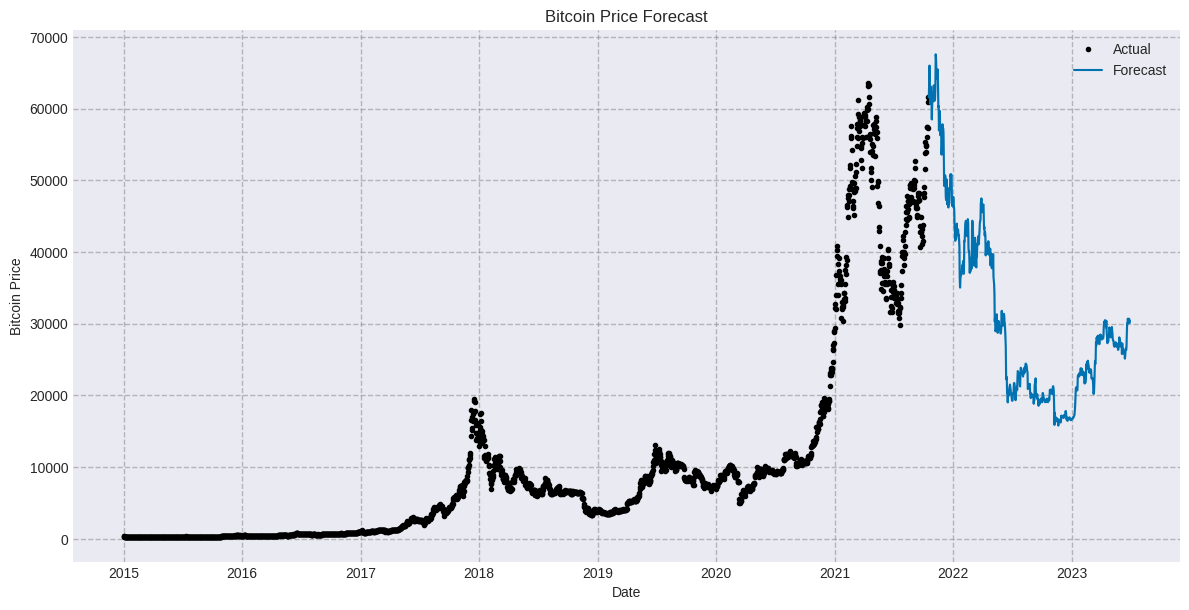

In [12]:
# Plotting the forecast

fig, ax = plt.subplots(figsize=(12, 6))
model.plot(forecast, ax=ax)

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
ax.set_title('Bitcoin Price Forecast')

# Add grid lines
ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.5)

# Add legend
ax.legend(['Actual', 'Forecast'])

# Display the plot
plt.show()


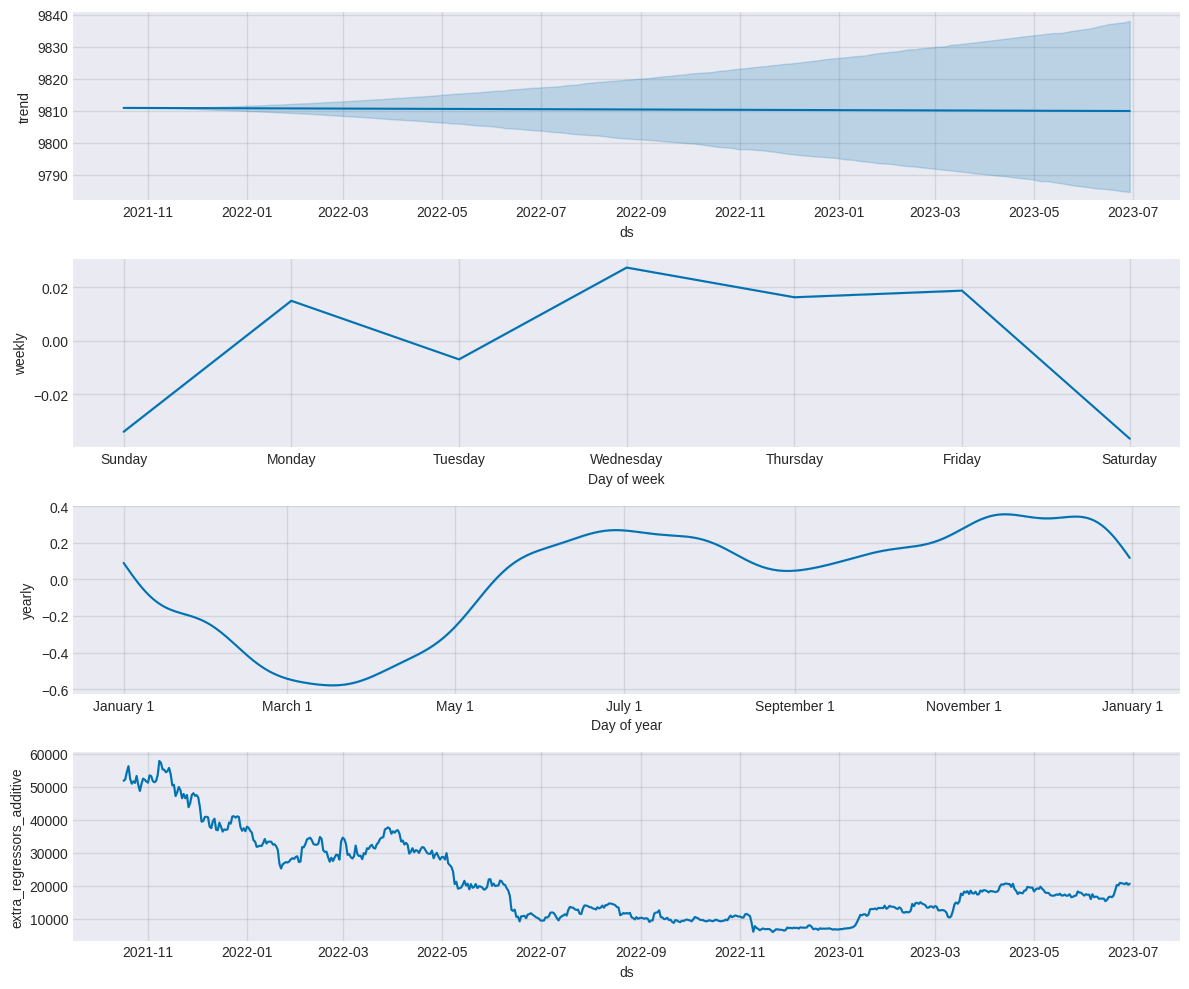

In [13]:
# Plotting the components

fig = model.plot_components(forecast, figsize=(12, 10))

# Customize the plot
plt.tight_layout()

# Display the plot
plt.show()


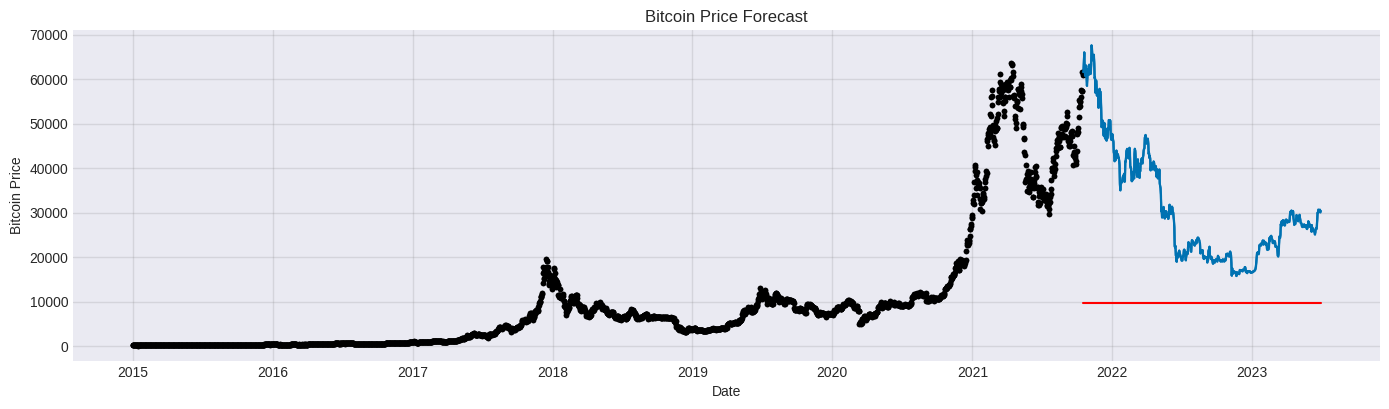

In [14]:
# Plotting the forecast
fig = model.plot(forecast, figsize=(14, 4))

# Add changepoints to the plot
model.plot(forecast, ax=fig.gca())

add_changepoints_to_plot(fig.gca(), model, forecast)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Forecast')

# Display the plot
plt.show()


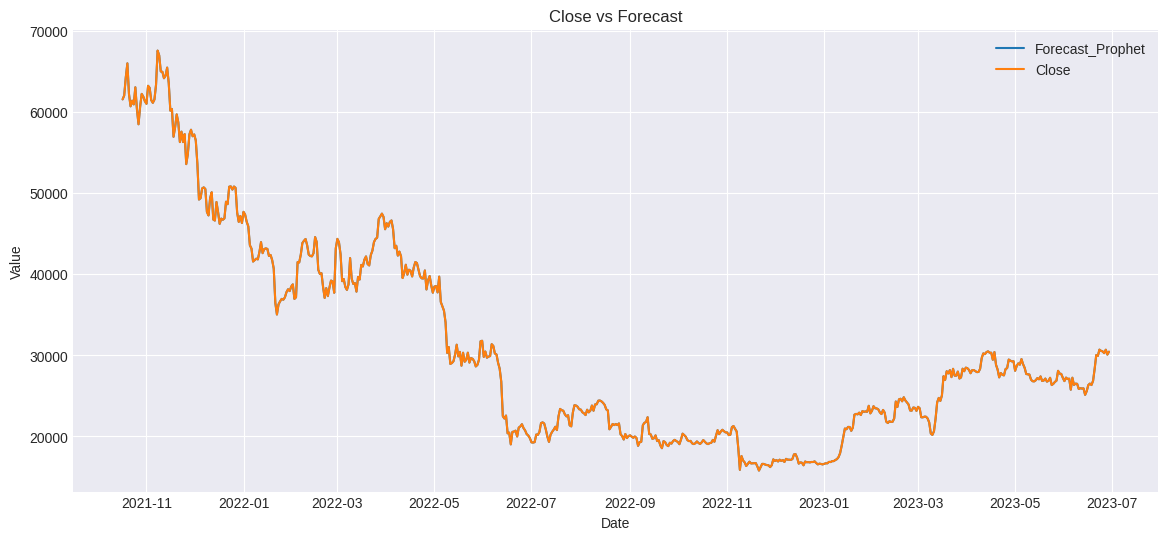

In [15]:
# Plotting Close and Forecast_Prophet with increased width

fig, ax = plt.subplots(figsize=(14, 6))

# Plotting Close and Forecast_Prophet
ax.plot(test_set["Date"], test_set["Forecast_Prophet"], label="Forecast_Prophet")
ax.plot(test_set["Date"], test_set["Close"], label="Close")


# Customize the plot
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.set_title("Close vs Forecast")
ax.legend()

# Display the plot
plt.show()

In [16]:
# Results Prophet Model

test_mae_prophet = round(mean_absolute_error(test_set['Close'], test_set['Forecast_Prophet']), 2)
test_rmse_prophet = round(np.sqrt(mean_squared_error(test_set['Close'], test_set['Forecast_Prophet'])), 2)
test_r2_prophet = round(r2_score(test_set['Close'], test_set['Forecast_Prophet'])*100, 2)

print(f"Prophet's Test MAE : {test_mae_prophet}")
print(f"Prophet's Test RMSE : {test_rmse_prophet}")
print(f"Prophet's Test R2 : {test_r2_prophet}")

Prophet's Test MAE : 0.99
Prophet's Test RMSE : 1.1
Prophet's Test R2 : 100.0


# Save Model

In [17]:
# save your model or results

# joblib.dump(model, '/content/drive/MyDrive/Colab Notebooks/01 Projects/Cryptocurrencies//Saved Models/BTC/model.pkl')

# load_fb = joblib.load("/content/drive/MyDrive/Colab Notebooks/01 Projects/Cryptocurrencies//Saved Models/ETH/model.pkl")

# load_fb